# Trabalho da disciplina de algoritmos não-supervisionados



In [18]:
import numpy as np
import scipy
import scipy.spatial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white", palette="pastel")
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm


## Data-preparation

In [19]:
#Leitura da base de dados proveniente do Kaggle

country_data = pd.read_csv("../../datasets/Country-data.csv")
country_data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [20]:
#Da descrição da base de dados fornecida pelo próprio site, temos as colunas de exports, imports e health como valores percetuais de gdpp

country_data['exports'] = country_data['exports']*country_data['gdpp']/100
country_data['imports'] = country_data['imports']*country_data['gdpp']/100
country_data['health'] = country_data['health']*country_data['gdpp']/100

In [21]:
# Verificando a presença de outliers para 25%,50%,75%,90%,95% and 99% dos dados
country_data.describe(percentiles=[.25,.5,.75,.90,.95,.99])

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
90%,100.220000,17760.600000,3825.416000,15034.280000,41220.000000,16.640000,80.400000,5.322000,41840.000000
95%,116.000000,31385.100000,4966.701000,24241.560000,48290.000000,20.870000,81.400000,5.861000,48610.000000
99%,153.400000,64794.260000,8410.330400,55371.390000,84374.000000,41.478000,82.370000,6.563600,79088.000000


### Boxplot

O boxplot realizado a seguir é, normalmente, utilizado para visualizar ou identificar se há presença de outliers nos dados, isto é, para visualizar se há dados muito afastados do centro de distribuição, afastados da média e da variância. Em outras palavras: para identificar dados discrepantes. Os dados que estiverem acima do último ponto superior são outliers.

/home/higoreller/miniconda3/envs/clustering-env/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


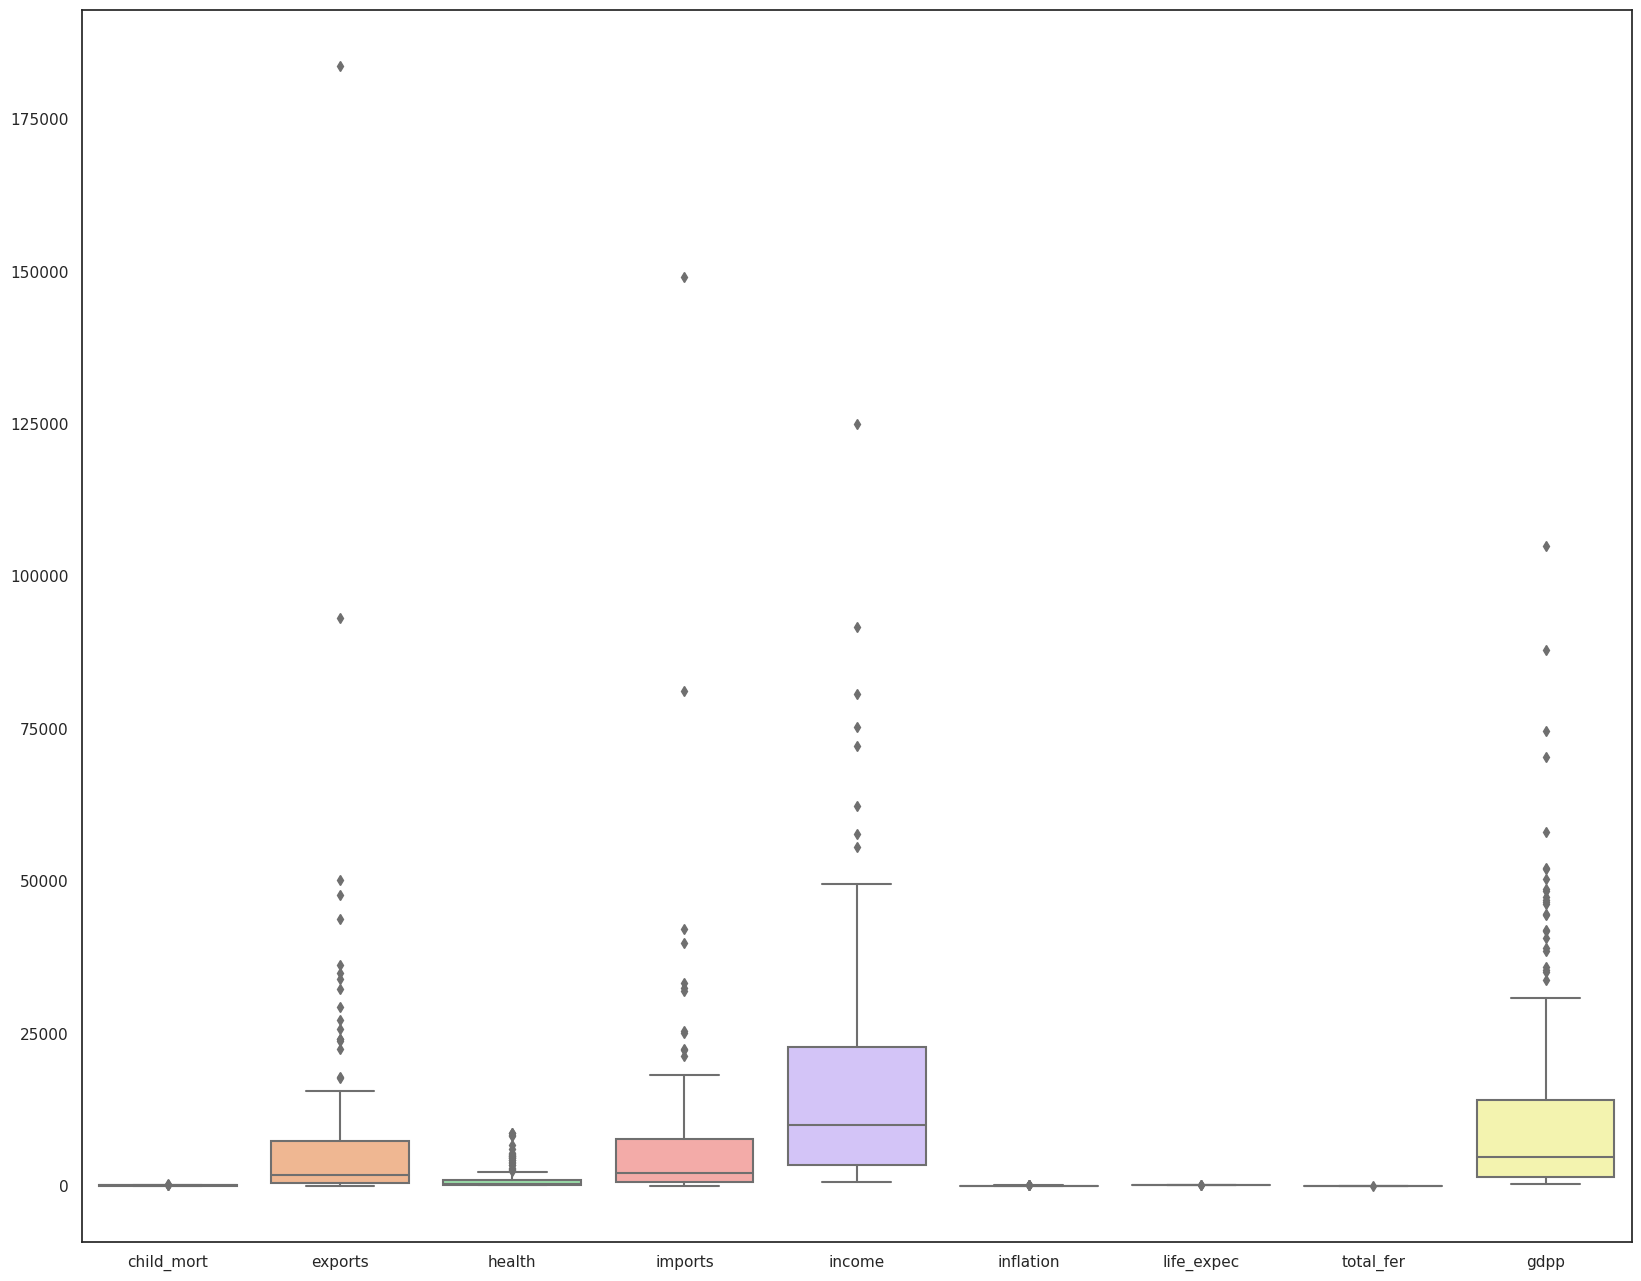

In [22]:
#Showing the box plot
fig = plt.figure(figsize = (20,16))
sns.boxplot(data=country_data)
plt.show()

In [23]:
print("O número de países é: ", country_data.shape[0])

O número de países é:  167


In [24]:
country_data.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

In [25]:
country_data.isna().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

## Método da Silhueta

In [26]:
# Removendo a coluna com os nomes dos países (string).
country_data_droped = country_data.drop('country', 1)
# Adotando o MinMaxScaler como normalizador. O StandardScaler e o RobustScaler também foram testados.
scaler = MinMaxScaler()
country_scaled = scaler.fit_transform(country_data_droped)

/tmp/ipykernel_1083/1252178063.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  country_data_droped = country_data.drop('country', 1)


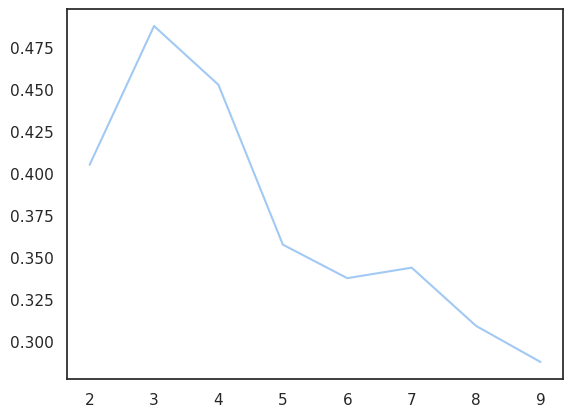

In [27]:
from sklearn.metrics import silhouette_score
sse_ = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k).fit(country_scaled)
    sse_.append([k, silhouette_score(country_scaled, kmeans.labels_)])
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.show()

In [28]:
#Definindo uma função para combinar com uma análise de K-médias e verificar como os clusters estão mergeados entre si.
def plot_clustering(data, labels, title=None):
    x_min, x_max = np.min(data, axis=0), np.max(data, axis=0)
    data = (data - x_min) / (x_max - x_min)
    fig = plt.figure(1, figsize=(4, 3))
    plt.figure(figsize=(16, 14))
    plt.scatter(data[:, 0], data[:, 1],
                 c=labels.astype(np.float))
    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis()
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

/tmp/ipykernel_1083/137002675.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=labels.astype(np.float))


<Figure size 400x300 with 0 Axes>

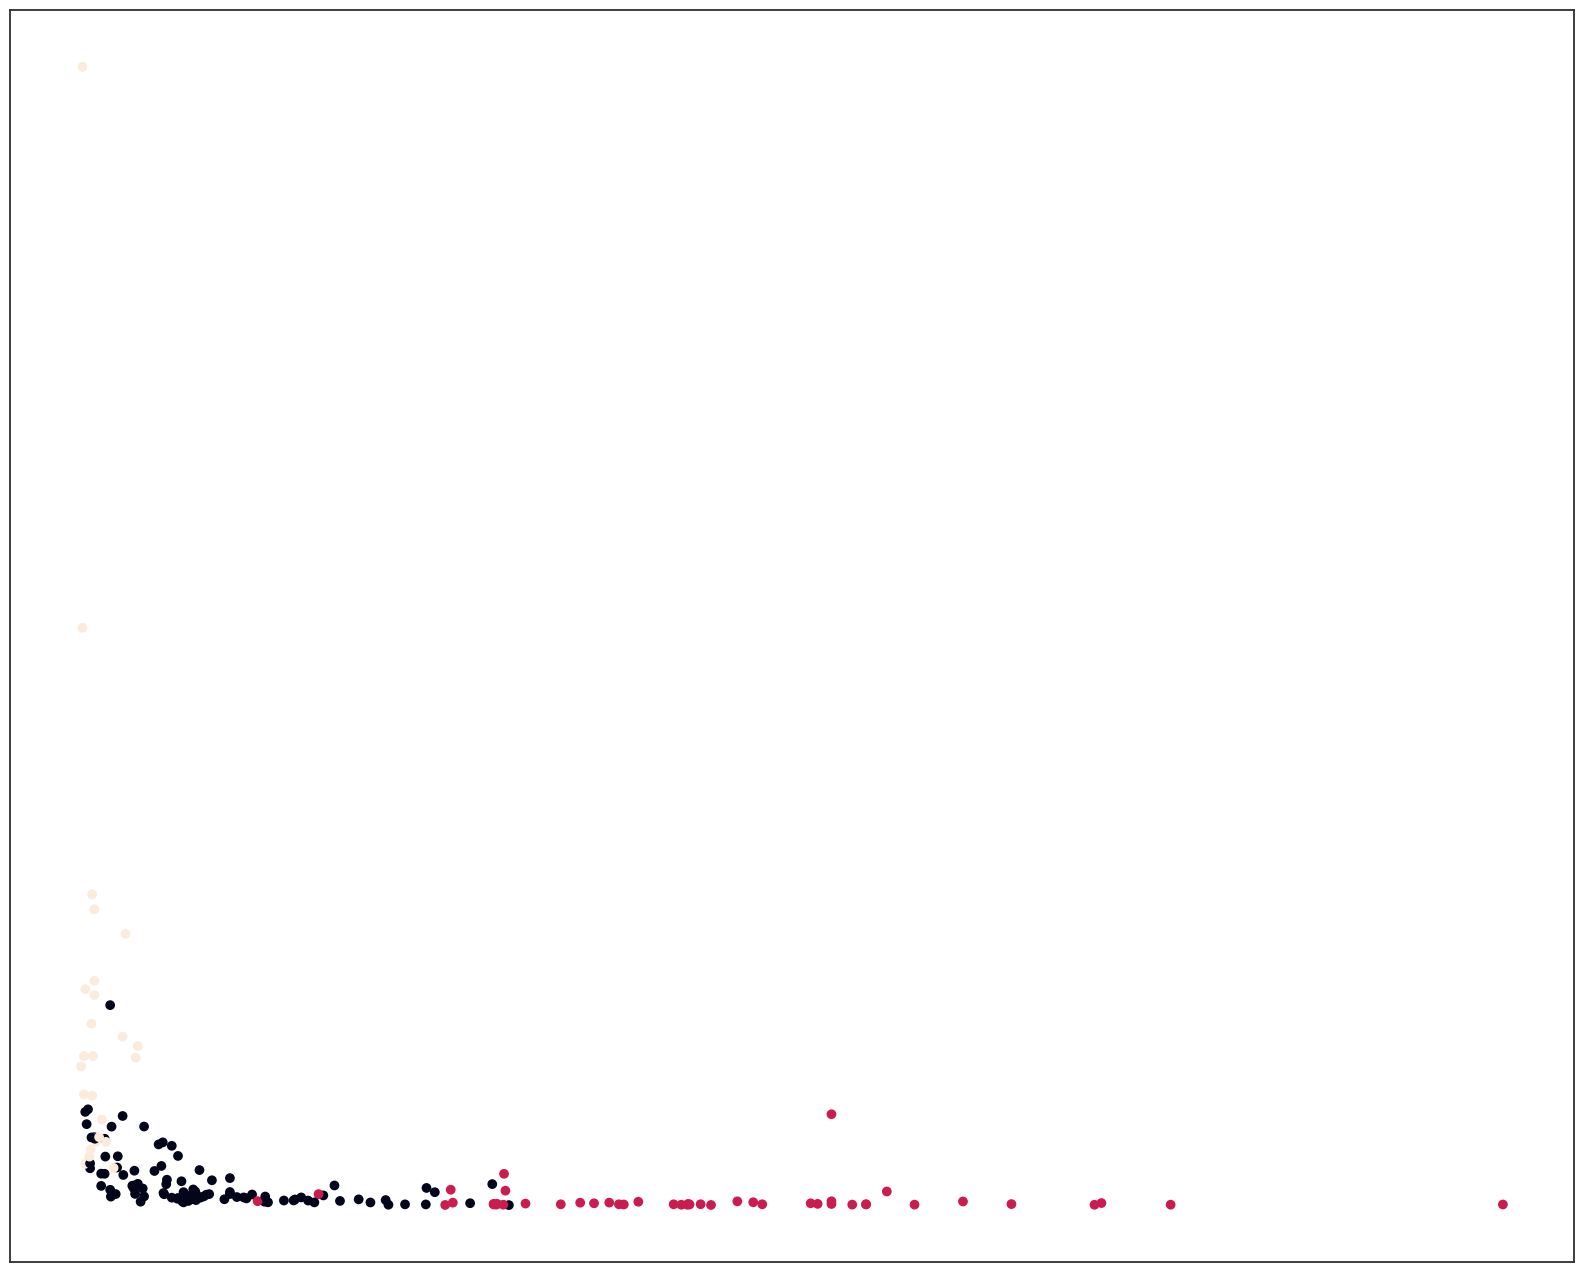

In [29]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(country_scaled)
labels = kmeans.labels_
plot_clustering(country_scaled, labels)
plt.show()

Para n_clusters = 2 O score_silhouette médio é : 0.4049257349993991
Para n_clusters = 3 O score_silhouette médio é : 0.48273445046434216
Para n_clusters = 4 O score_silhouette médio é : 0.45256849722968046
Para n_clusters = 5 O score_silhouette médio é : 0.35715664308613154
Para n_clusters = 6 O score_silhouette médio é : 0.37121842307846636


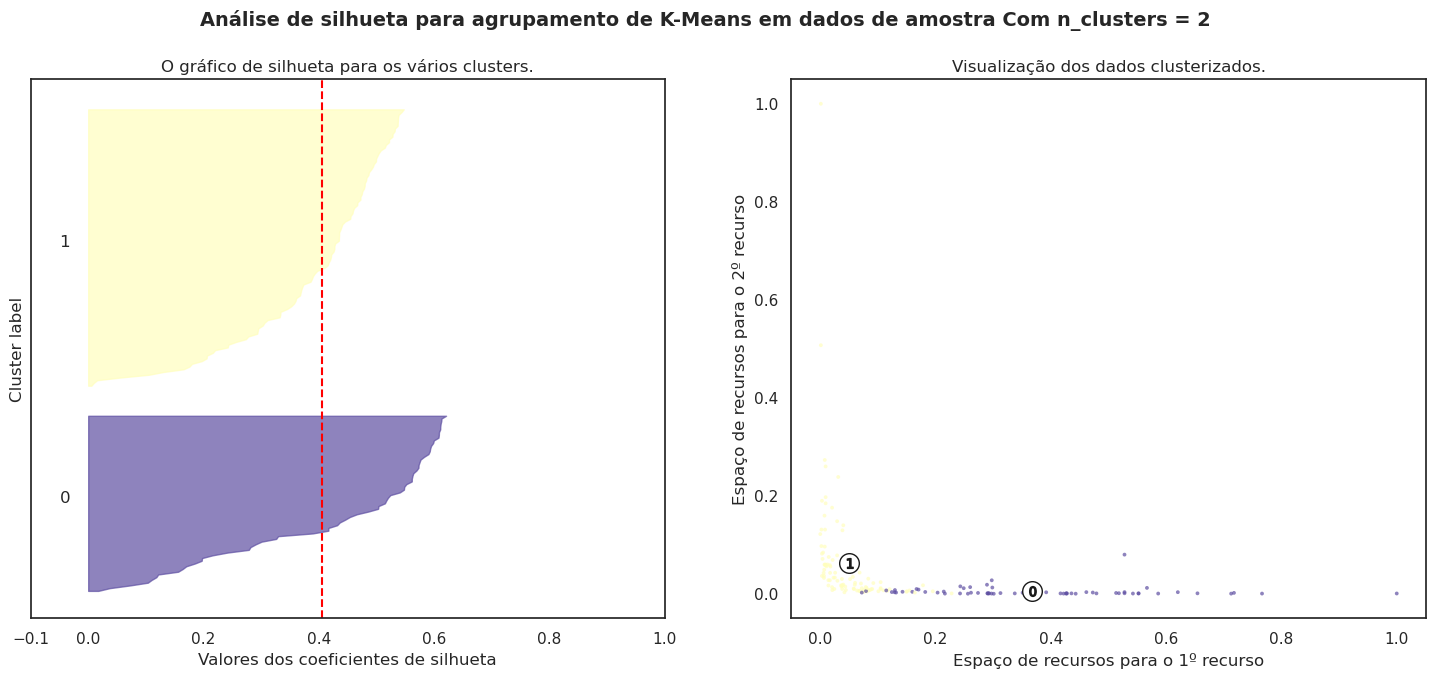

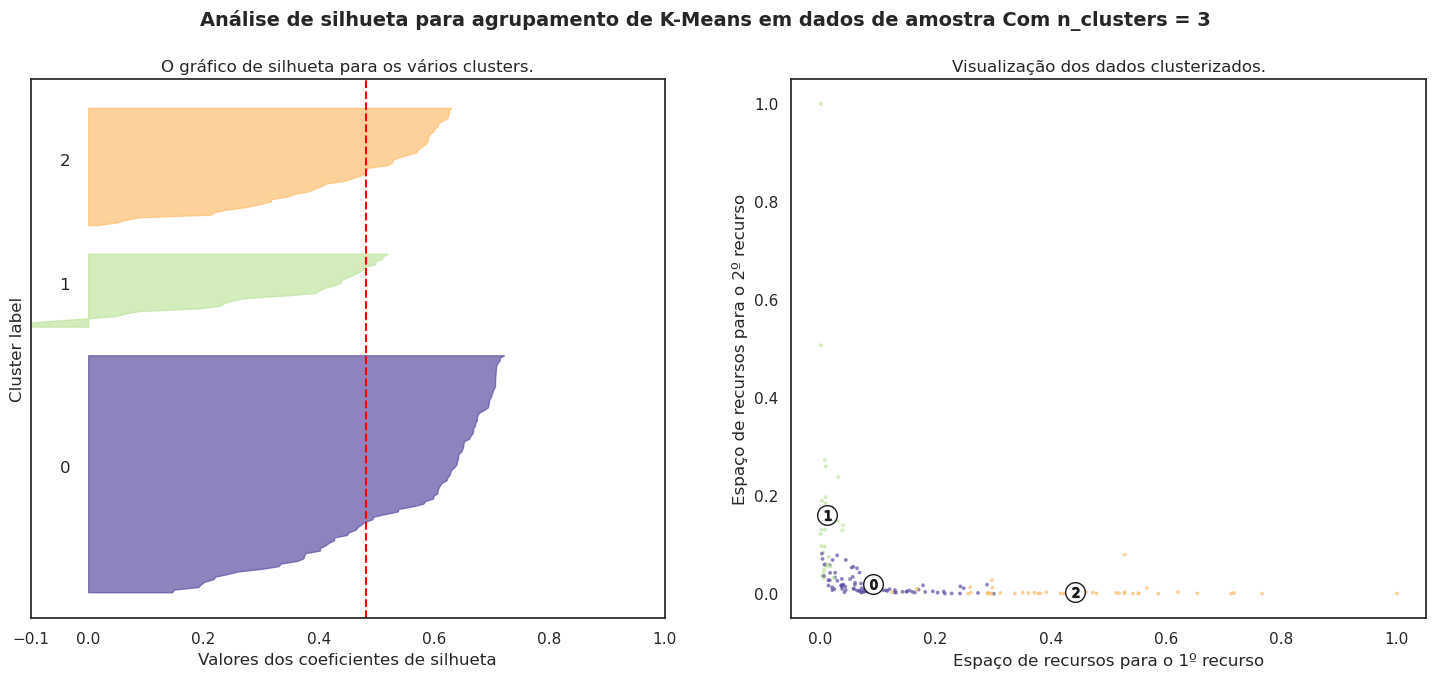

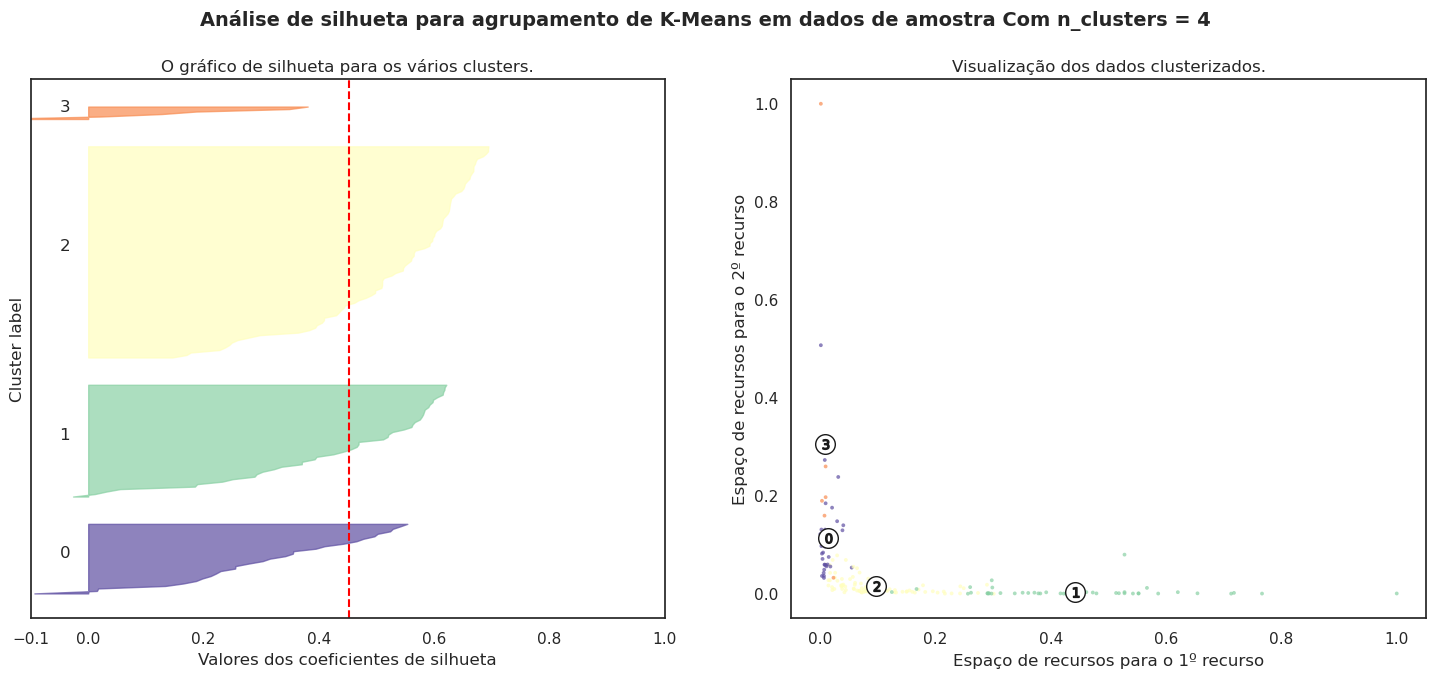

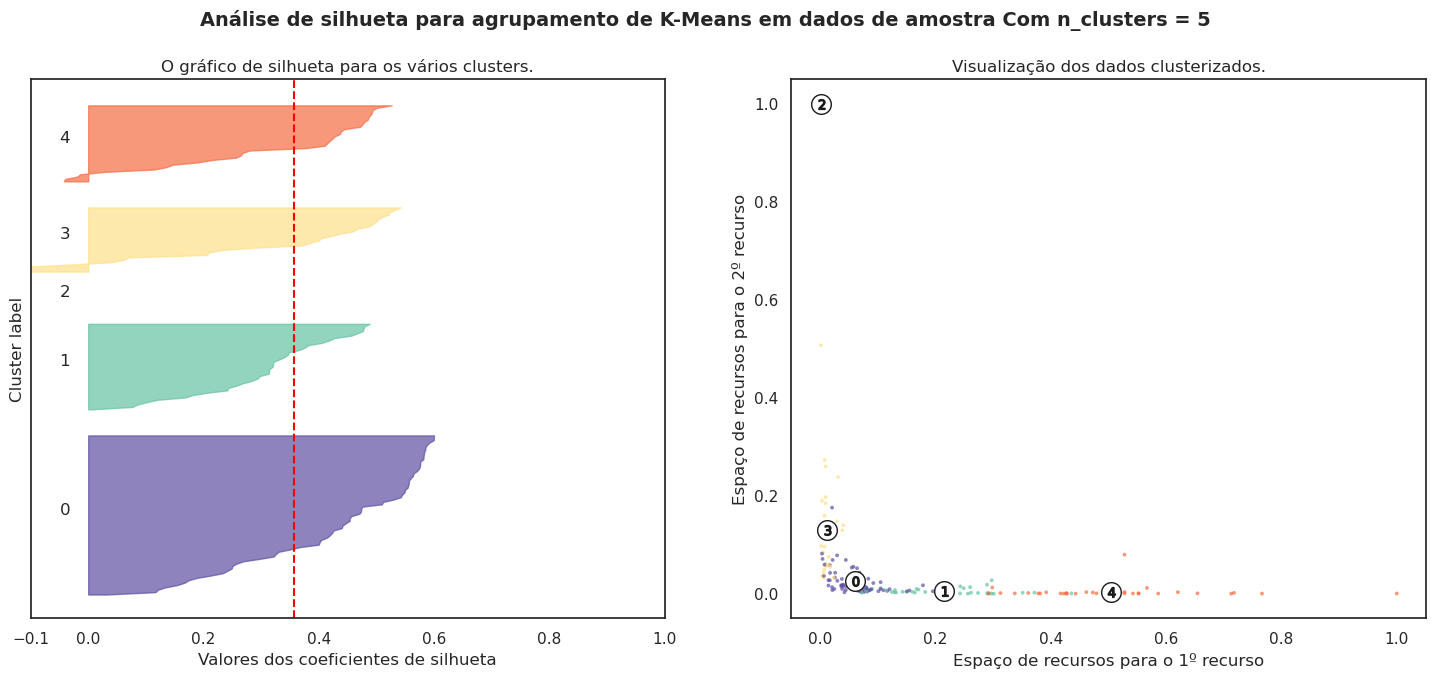

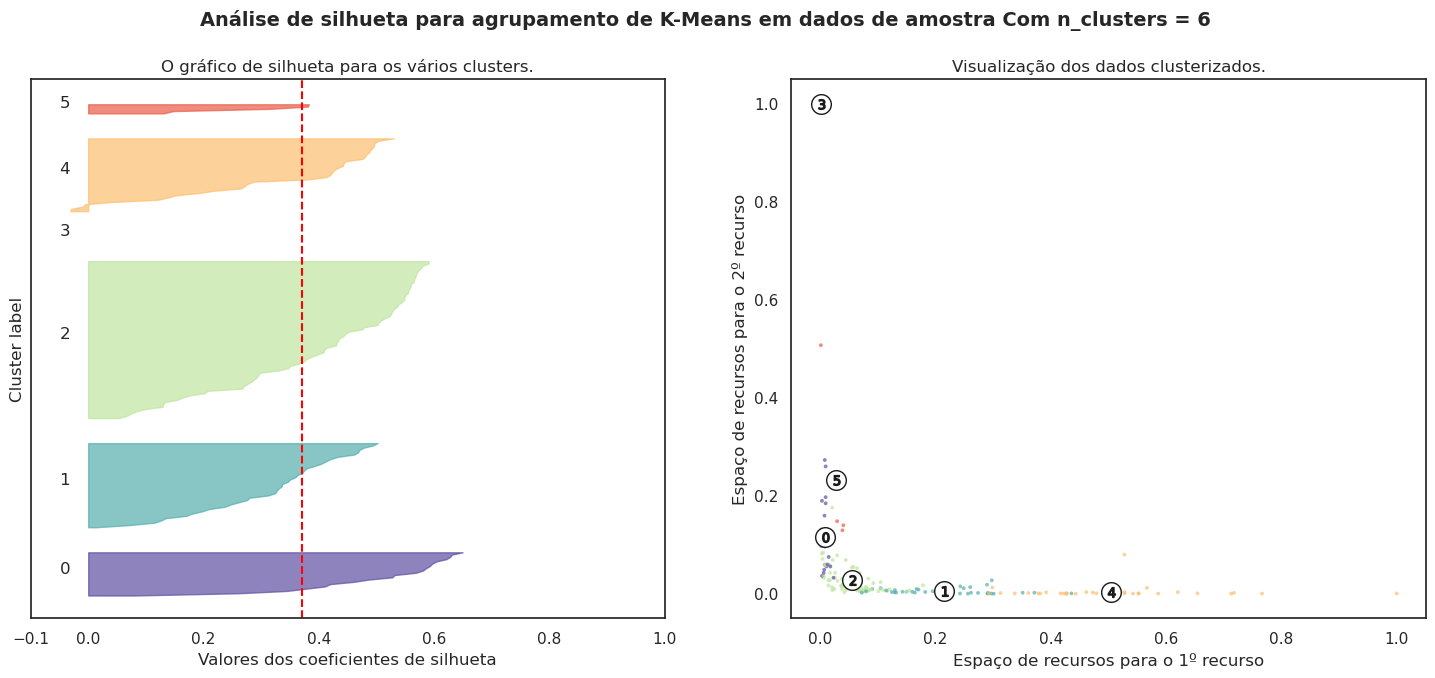

In [30]:
#Obtendo os coeficientes de silhueta para verificar se os dados possuem estrutura razoável para serem clusterizados em 3 clusters
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    #Criando um subplot com uma linha e duas colunas
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    #Os coeficientes de silhueta irão variar entre [-0.1, 1]
    ax1.set_xlim([0, 1])
    #O (n_clusters+1)*10 é para inserir espaço em branco entre os agrupamentos individuais, para demarcá-los claramente.
    ax1.set_ylim([0, len(country_scaled) + (n_clusters + 1) * 10])
    #Inicializando a clusterização com um número n_clusters e com a seed de 33 para assegurar a reprodutibilidade dos resultados
    clusterer = KMeans(n_clusters=n_clusters, random_state=33)
    cluster_labels = clusterer.fit_predict(country_scaled)
    #O silhouette_score dá o valor médio para todas as amostras.
    #Isso dá uma perspectiva sobre a densidade e separação dos clusters formados.
    silhouette_avg = silhouette_score(country_scaled, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "O score_silhouette médio é :", silhouette_avg)
    #Calculando as pontuações da silhueta para cada amostra
    sample_silhouette_values = silhouette_samples(country_scaled, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        # Agregando as pontuações de silhueta para amostras pertencentes a i e classificá-las
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral_r")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        #Rotulando os gráficos de silhueta com seus números de cluster no meio
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        #Calculando o novo y_lower para o próximo gráfico
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("O gráfico de silhueta para os vários clusters.")
    ax1.set_xlabel("Valores dos coeficientes de silhueta")
    ax1.set_ylabel("Cluster label")
    #Linha vertical para a pontuação média da silhueta de todos os valores
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    #2º gráfico mostrando os clusters reais formados
    cmap = cm.get_cmap("Spectral_r")
    colors = cmap(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(country_scaled[:, 0], country_scaled[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    #Rotulando os clusters
    centers = clusterer.cluster_centers_
    #Desenhando círculos brancos nos centros dos clusters
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("Visualização dos dados clusterizados.")
    ax2.set_xlabel("Espaço de recursos para o 1º recurso")
    ax2.set_ylabel("Espaço de recursos para o 2º recurso")
    plt.suptitle(("Análise de silhueta para agrupamento de K-Means em dados de amostra "
                  "Com n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

## Método do Cotovelo

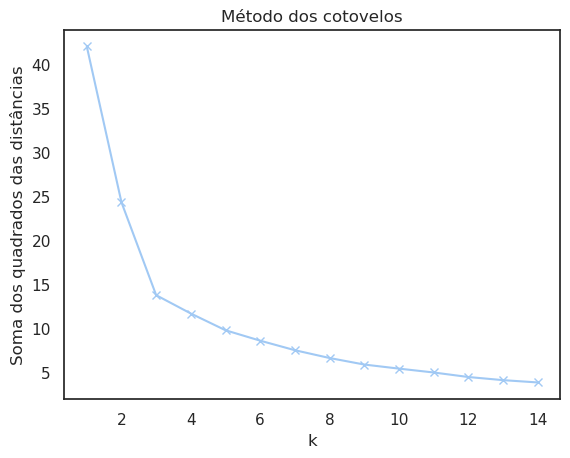

In [31]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(country_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma dos quadrados das distâncias')
plt.title('Método dos cotovelos')
plt.show()

## Clustering

In [32]:
kmeans = KMeans(n_clusters=3)
k_fit = kmeans.fit(country_scaled)

Text(0, 0.5, 'Proporção cumulativa de variância')

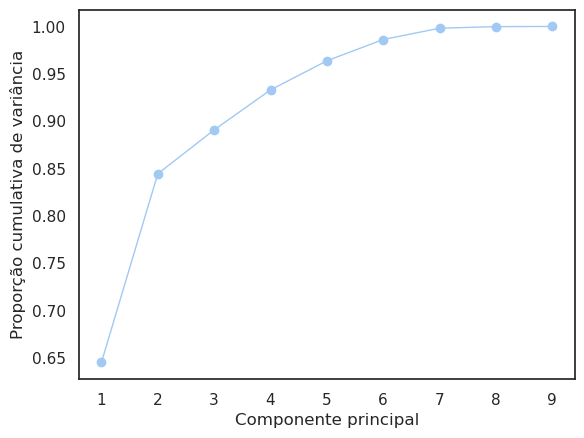

In [33]:
#Analisando o acúmulo da variância em função dos componentes
country_pca = PCA()
pca = country_pca.fit_transform(country_scaled)
plt.plot(np.arange(1,10), np.cumsum(country_pca.explained_variance_ratio_), 'o-', linewidth='1')
plt.xlabel('Componente principal')
plt.ylabel('Proporção cumulativa de variância')

Dois componentes acumulam 85% da variância, portanto o problema será reduzido a duas dimensões.

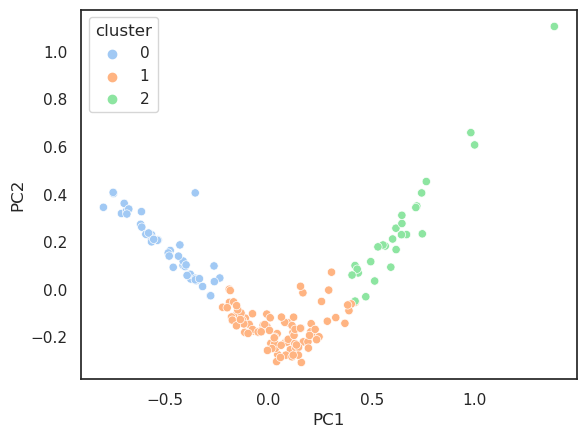

In [34]:
#Utilizando dois componentes principais
def plot_cluster_points(df, kmeans):
    pca = PCA(2) 
    pca_data = pd.DataFrame(pca.fit_transform(df), columns=['PC1','PC2']) 
    pca_data['cluster'] = pd.Categorical(kmeans.labels_)
    sns.scatterplot(x="PC1", y="PC2", hue="cluster", data=pca_data)

plot_cluster_points(country_scaled, kmeans)

## Hierarchical clustering

Text(0, 0.5, 'Distância Euclidiana')

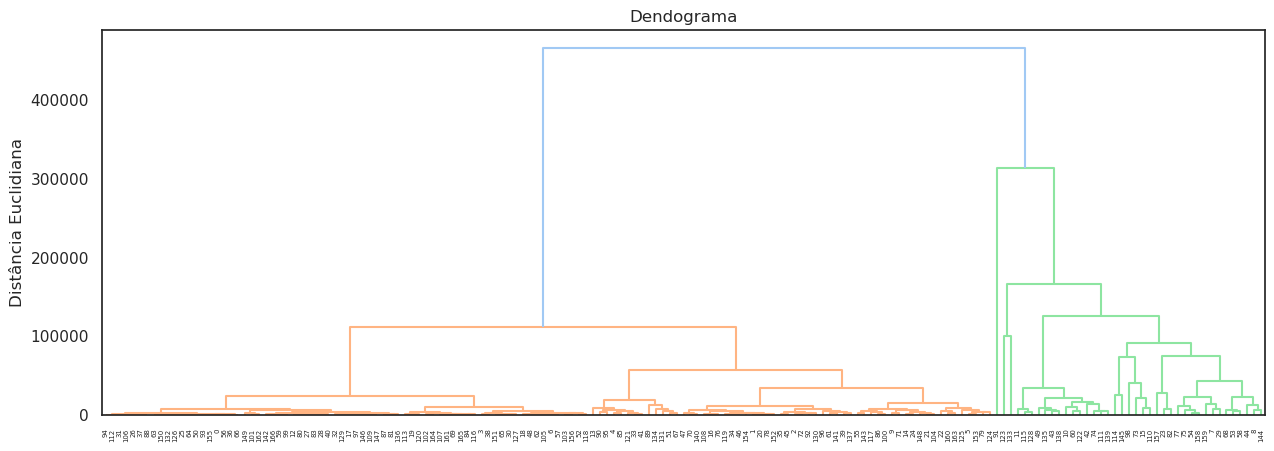

In [35]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15, 5))
plt.grid(False)
dendrogram = sch.dendrogram(sch.linkage(country_data_droped, method='ward'), labels=country_data_droped.index)
plt.title('Dendograma')
plt.ylabel('Distância Euclidiana')